In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode, pearsonr
import csv
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from datetime import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

%matplotlib inline

In [4]:
# 原始数据
df = pd.read_csv('./data/round2_train.txt', sep=' ', na_values='-1')
dfA = pd.read_csv('./data/round2_ijcai_18_test_a_20180425.txt', sep=' ', na_values='-1')
originDf = pd.concat([df,dfA], ignore_index=True)

print(df.info())
print(dfA.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10432036 entries, 0 to 10432035
Data columns (total 27 columns):
instance_id                  int64
item_id                      int64
item_category_list           object
item_property_list           object
item_brand_id                float64
item_city_id                 float64
item_price_level             int64
item_sales_level             float64
item_collected_level         int64
item_pv_level                int64
user_id                      int64
user_gender_id               float64
user_age_level               float64
user_occupation_id           float64
user_star_level              float64
context_id                   int64
context_timestamp            int64
context_page_id              int64
predict_category_property    object
shop_id                      int64
shop_review_num_level        int64
shop_review_positive_rate    float64
shop_star_level              int64
shop_score_service           float64
shop_score_delivery     

In [5]:
# 原始数据各日期数据量及转化率
tempDf = df.drop_duplicates()
tempDf['context_timestamp'] = tempDf['context_timestamp'].map(lambda x: datetime.fromtimestamp(x))
tempDf['date'] = pd.to_datetime(tempDf.context_timestamp.dt.date)
print(tempDf['date'].value_counts())
tempDf2 = pd.pivot_table(tempDf, index=['date'], values='is_trade', aggfunc=np.mean)
print(tempDf2)

2018-09-06    1934443
2018-09-01    1340697
2018-09-02    1289476
2018-09-03    1236828
2018-09-05    1200219
2018-08-31    1195557
2018-09-04    1157641
2018-09-07    1077175
Name: date, dtype: int64
            is_trade
date                
2018-08-31  0.012838
2018-09-01  0.013609
2018-09-02  0.013290
2018-09-03  0.012378
2018-09-04  0.011367
2018-09-05  0.009772
2018-09-06  0.005498
2018-09-07  0.046089


初步打算：倒数第二天做统计，当天做训练

前5天视为平常日期，抽样0.3方便做数据分析

In [2]:
# 抽样后数据读取
df1 = pd.read_csv('./data/round2_train_h4_sample.txt', sep=' ', na_values='-1')
df2 = pd.read_csv('./data/round2_train_t2.txt', sep=' ', na_values='-1')
df = pd.concat([df1,df2], ignore_index=True)

print(df1.info())
print(df2.info())
print(df.info())
df = df.sample(frac=0.5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518767 entries, 0 to 1518766
Data columns (total 28 columns):
Unnamed: 0                   1518767 non-null int64
instance_id                  1518767 non-null int64
item_id                      1518767 non-null int64
item_category_list           1518767 non-null object
item_property_list           1518766 non-null object
item_brand_id                1454908 non-null float64
item_city_id                 1517756 non-null float64
item_price_level             1518767 non-null int64
item_sales_level             1512651 non-null float64
item_collected_level         1518767 non-null int64
item_pv_level                1518767 non-null int64
user_id                      1518767 non-null int64
user_gender_id               1482723 non-null float64
user_age_level               1515173 non-null float64
user_occupation_id           1515173 non-null float64
user_star_level              1515173 non-null float64
context_id                   1518767 no

In [3]:
# 单维度转化率评价
def printSingleFeaLine(df, cols):
    tempDf = df.fillna(-9999)
    for c in cols:
        print(tempDf[c].value_counts())
        plt.figure(figsize=(15,5))
        sns.pointplot(x=c, y='is_trade', data=tempDf, hue='dataset',dodge=True)

In [4]:
# 计算转化皮尔森系数
def getFeaPearsonr(df, cols):
    resultDf = pd.DataFrame(index=cols, columns=['pearsonr','p_values'])
    for c in cols:
        tempDf = df.dropna(subset=[c])
        result = pearsonr(tempDf[c].values, tempDf['is_trade'].values)
        resultDf.loc[c,:] = result
    return resultDf

In [5]:
# 转化数据集字段格式，拆分组合特征
def formatDf(df):
    df.drop_duplicates(inplace=True)
    df['context_timestamp'] = df['context_timestamp'].map(lambda x: datetime.fromtimestamp(x))
    tempDf = df.drop_duplicates(subset=['item_id'])[['item_id','item_category_list','item_property_list']]
    tempDf['item_category_list'] = tempDf[tempDf.item_category_list.notnull()]['item_category_list'].map(lambda x: x.split(';'))
    tempDf['item_category0'] = tempDf[tempDf.item_category_list.notnull()]['item_category_list'].map(lambda x: x[0])
    tempDf['item_category1'] = tempDf[tempDf.item_category_list.notnull()]['item_category_list'].map(lambda x: x[1] if len(x)>1 else np.nan)
    tempDf['item_category2'] = tempDf[tempDf.item_category_list.notnull()]['item_category_list'].map(lambda x: x[2] if len(x)>2 else np.nan)
    tempDf['item_property_list'] = tempDf[tempDf.item_property_list.notnull()]['item_property_list'].map(lambda x: x.split(';'))
    df = df.drop(['item_category_list','item_property_list'], axis=1).merge(tempDf, how='left', on='item_id')
    df['predict_category_property'] = df[df.predict_category_property.notnull()]['predict_category_property'].map(
        lambda x: {kv.split(':')[0]:(kv.split(':')[1].split(',') if kv.split(':')[1]!='-1' else []) for kv in x.split(';')})
    df['user_item'] = df['user_id'].astype('str') + '_' + df['item_id'].astype('str')
    return df

In [6]:
# 添加时间特征
def addTimeFea(df, **params):
    df['hour'] = df.context_timestamp.dt.hour
    df['minute'] = df.context_timestamp.dt.minute
    df['date'] = pd.to_datetime(df.context_timestamp.dt.date)
    return df

In [7]:
# 将数据字段格式化
df = formatDf(df)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2265192 entries, 0 to 2265191
Data columns (total 32 columns):
Unnamed: 0                   int64
instance_id                  int64
item_id                      int64
item_brand_id                float64
item_city_id                 float64
item_price_level             int64
item_sales_level             float64
item_collected_level         int64
item_pv_level                int64
user_id                      int64
user_gender_id               float64
user_age_level               float64
user_occupation_id           float64
user_star_level              float64
context_id                   int64
context_timestamp            datetime64[ns]
context_page_id              int64
predict_category_property    object
shop_id                      int64
shop_review_num_level        int64
shop_review_positive_rate    float64
shop_star_level              int64
shop_score_service           float64
shop_score_delivery          float64
shop_score_descri

In [8]:
# 添加时间特征
df = addTimeFea(df)

In [9]:
# 添加数据集标记
df.loc[df.date<'2018-09-05','dataset'] = 0
df.loc[(df.date>='2018-09-05')&(df.date<'2018-09-07'),'dataset'] = 1
df.loc[df.date=='2018-09-07','dataset'] = 2

In [12]:
# 暂时加入测试集数据作全天时间段统计分析
predictDf = pd.read_csv('./data/round2_ijcai_18_test_a_20180425.txt', sep=' ', na_values='-1')
predictDf = predictDf.sample(frac=0.5)
predictDf = formatDf(predictDf)
predictDf = addTimeFea(predictDf)
originDf = pd.concat([df,predictDf], ignore_index=True)

            len                                                         \
date 2018-08-31 2018-09-01 2018-09-02 2018-09-03 2018-09-06 2018-09-07   
hour                                                                     
0      0.021122   0.023045   0.022222   0.021749   0.014709   0.063054   
1      0.008852   0.010399   0.010055   0.009790   0.006776   0.034237   
2      0.005248   0.005454   0.005705   0.006017   0.004048   0.015458   
3      0.003872   0.004138   0.004612   0.004306   0.003055   0.009095   
4      0.004017   0.003918   0.004174   0.004360   0.002966   0.006911   
5      0.005517   0.005613   0.006030   0.006324   0.004437   0.008649   
6      0.015527   0.015663   0.015131   0.016050   0.010979   0.019701   
7      0.028245   0.029915   0.026345   0.027051   0.017858   0.037851   
8      0.032117   0.036031   0.035889   0.037524   0.026143   0.044599   
9      0.038155   0.040169   0.046511   0.047702   0.034469   0.048124   
10     0.044936   0.049386   0.055117 

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


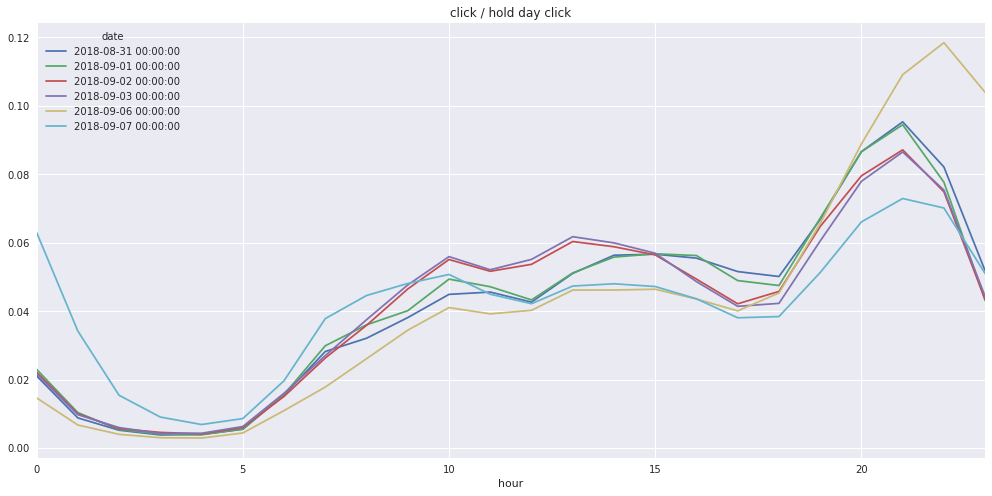

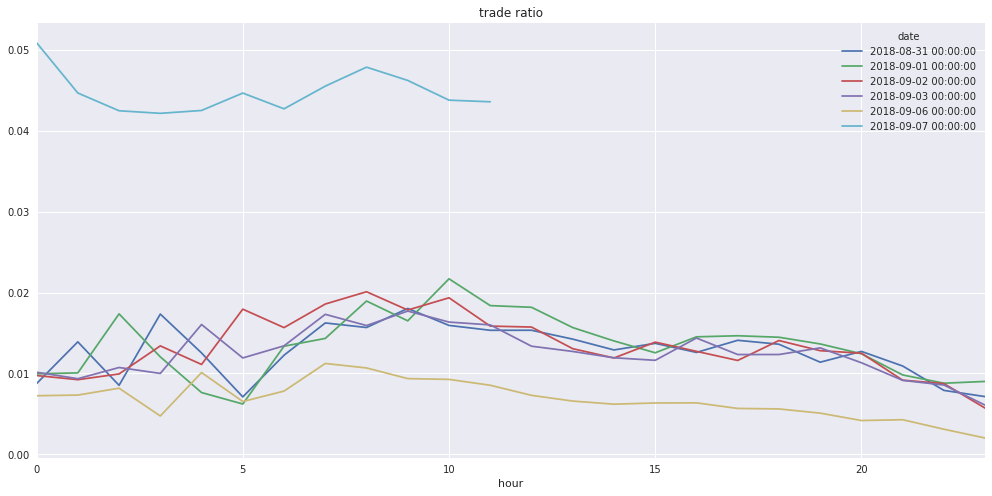

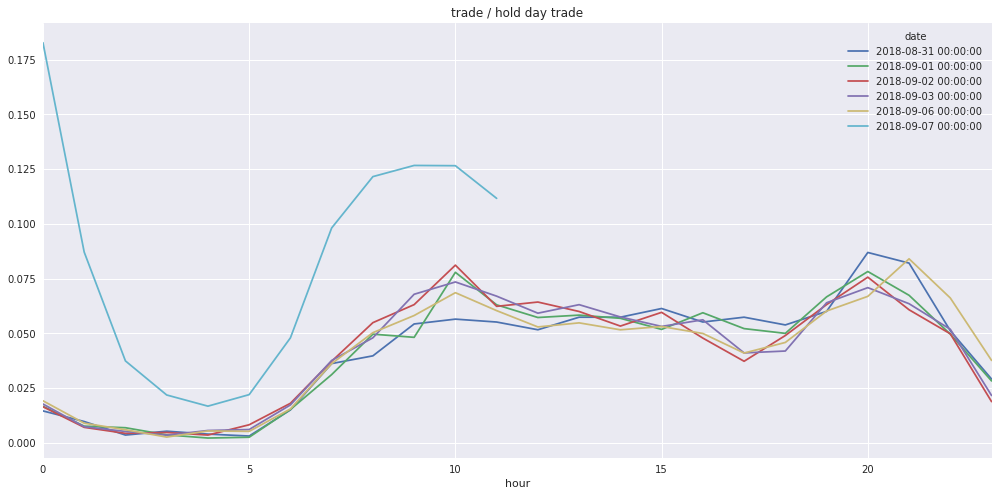

In [13]:
# 查看时段数据分布情况
tempDf = pd.pivot_table(originDf, index='hour', columns='date', values='is_trade', aggfunc=[len,np.mean,np.sum])
tempDf.loc[12:23,pd.IndexSlice['len','2018-09-07']] = tempDf.loc[12:23,pd.IndexSlice['len','2018-09-07']].values.reshape(12) / 0.3
tempDf['len'] = tempDf['len'].apply(lambda x: x / x.sum())
tempDf['sum'] = tempDf['sum'].apply(lambda x: x / x.sum())
print(tempDf)
print(tempDf['len'].plot(figsize=(17,8)))
plt.title('click / hold day click')
print(tempDf['mean'].plot(figsize=(17,8)))
plt.title('trade ratio')
print(tempDf['sum'].plot(figsize=(17,8)))
plt.title('trade / hold day trade')

10    382803
5     382497
6     382100
7     381959
9     381161
8     380645
4     379662
11    378020
3     376465
2     374276
1     368236
0     362561
Name: minute_hist, dtype: int64


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


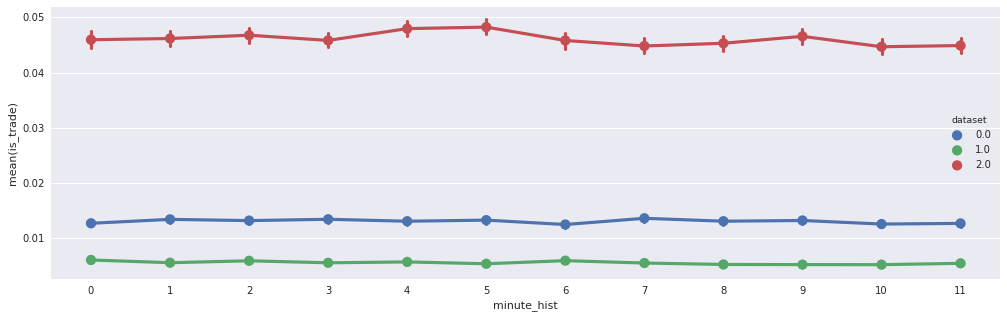

In [14]:
# 考虑分钟是否与转化率有关
tempDf = df.copy()
tempDf['minute_hist'] = tempDf.minute // 5
print(tempDf['minute_hist'].value_counts())
plt.figure(figsize=(17,5))
sns.pointplot(x='minute_hist', y='is_trade', data=tempDf, hue='dataset')
# plt.figure(figsize=(17,5))
# sns.pointplot(x='minute_hist', y='is_trade', data=tempDf, hue='hour2',dodge=True,palette='Paired')

并没有看出分钟上的什么规律，不考虑

cate0: 836752724084922533    2265192
Name: item_category0, dtype: int64
cate2 in cate1:
 597424223456586363     12
5066527928272238333    10
453525480366550911      8
2211060154630359130     7
3613783563199627217     6
5685690139879409547     5
2871729383671301763     4
3089254302947620489     2
6254910033820815248     2
7423553047267511438     2
3434689896486063330     2
Name: item_category1, dtype: int64
11.0    349648
10.0    338337
12.0    315105
9.0     273589
13.0    209409
8.0     203024
7.0     146347
14.0    124816
6.0      94889
5.0      60132
15.0     46697
4.0      35290
3.0      21402
16.0     15479
2.0      10700
0.0      10466
1.0       6426
17.0      3436
Name: item_sales_level, dtype: int64
7     717245
6     607842
8     413288
5     289158
4     102270
9      86033
3      20067
10     15649
2       8955
1       4685
Name: item_price_level, dtype: int64
12    380179
13    370793
11    331297
10    265285
14    255924
9     175124
15    152043
8     112284
7      73343

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


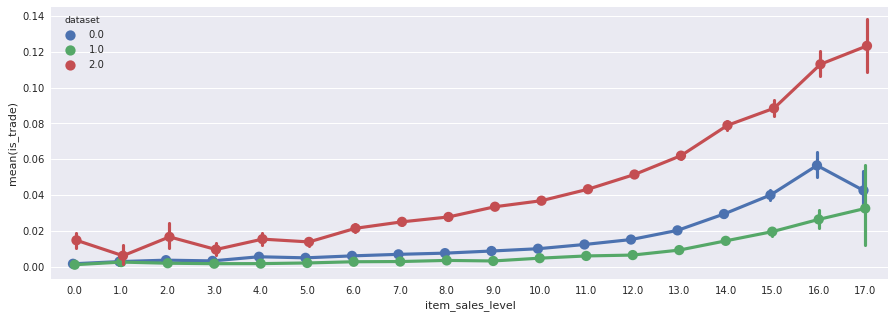

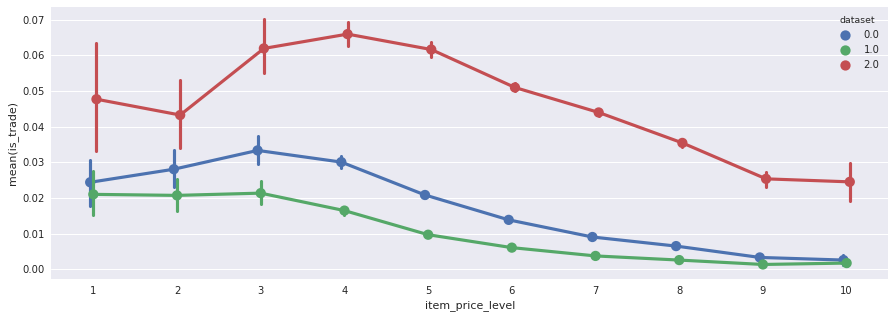

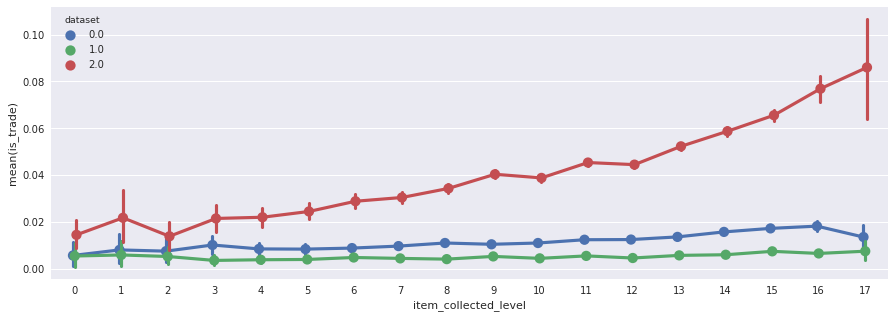

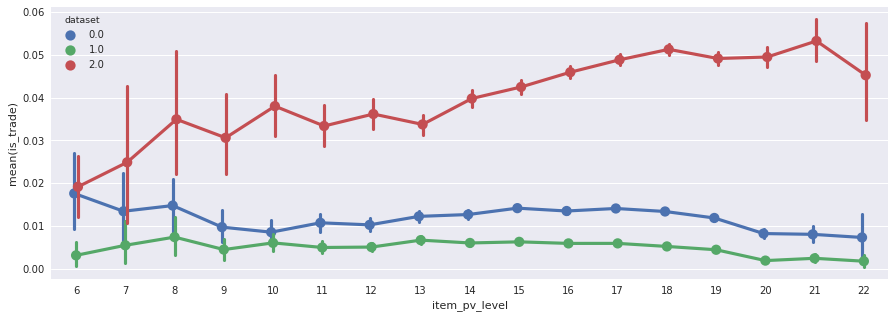

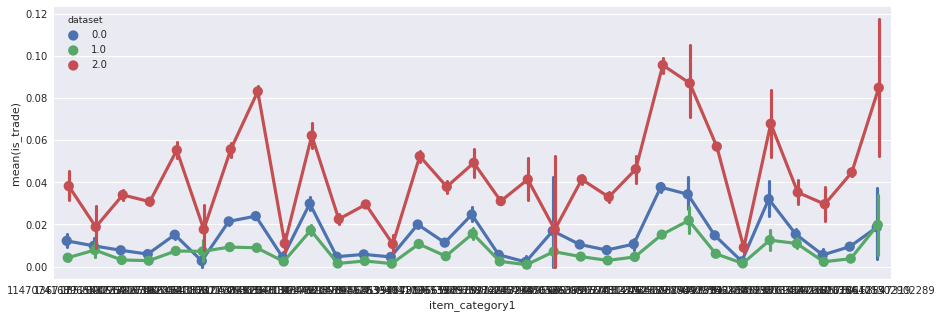

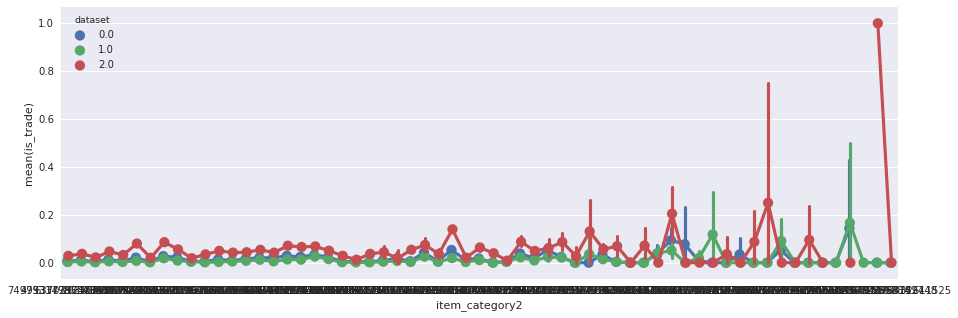

In [26]:
# 商品特征
cols = ['item_sales_level','item_price_level','item_collected_level','item_pv_level','item_category1','item_category2']
print('cate0:',df.item_category0.value_counts())
tempDf = df.dropna(subset=['item_category2']).drop_duplicates(subset=['item_category2'])
print('cate2 in cate1:\n', tempDf['item_category1'].value_counts())
tempDf = df.copy()
tempDf.loc[tempDf.item_sales_level.isnull(), 'item_sales_level'] = 0
tempDf.loc[tempDf.item_price_level<1, 'item_price_level'] = 1
tempDf.loc[tempDf.item_price_level>10, 'item_price_level'] = 10
tempDf.loc[tempDf.item_collected_level>17, 'item_collected_level'] = 17
tempDf.loc[tempDf.item_pv_level<6, 'item_pv_level'] = 6
printSingleFeaLine(tempDf, cols)

+ 销量特征：复赛该特征出现缺失值，根据曲线趋势和缺失数量，基本可以把缺失值当作一种特征值处理
+ 价格特征：LEVEL0商品数量过少，合并进LEVEL1处理。11跟12合并进10
+ 收藏特征：18合并进17
+ 广告特征：1～5合并进6级
+ 类目特征：一级类目增至31个，个别类目数目较少。其中11个有二级类目,且二级类目数较多。因此不适合合并类目统计

 0.0       1738109
 1.0        410770
-9999.0      63596
 2.0         52717
Name: user_gender_id, dtype: int64
 1003.0    823262
 1004.0    583621
 1002.0    363542
 1005.0    258988
 1006.0    126913
 1000.0     54977
 1001.0     24840
 1007.0     23918
-9999.0      5131
Name: user_age_level, dtype: int64
 3006.0    426065
 3003.0    328659
 3005.0    327733
 3007.0    294058
 3004.0    288623
 3002.0    259089
 3000.0    120110
 3008.0    116959
 3001.0     75714
 3009.0     23051
-9999.0      5131
Name: user_star_level, dtype: int64
 2005.0    1317554
 2002.0     782654
 2004.0     127770
 2003.0      32083
-9999.0       5131
Name: user_occupation_id, dtype: int64


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


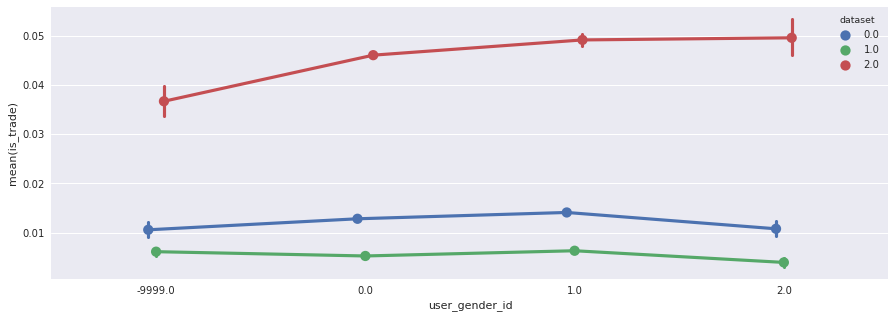

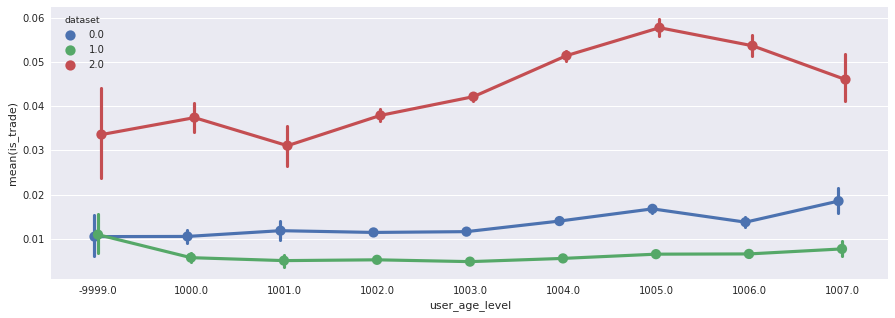

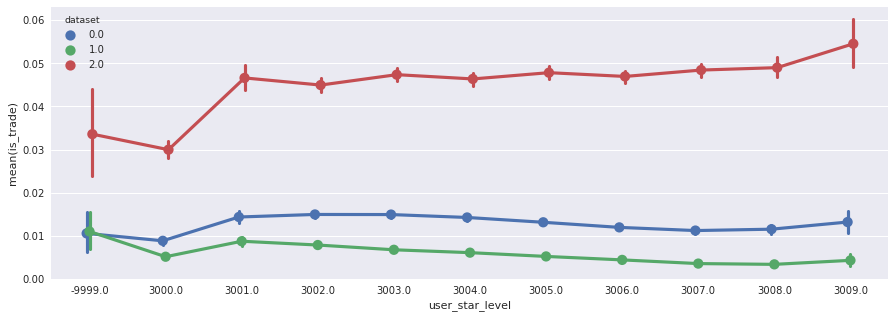

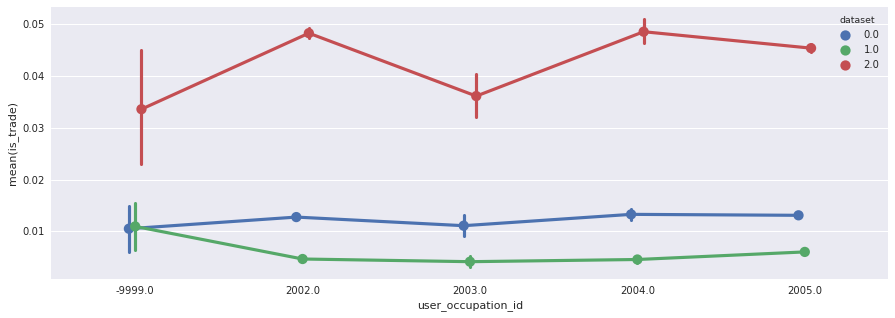

In [28]:
# 用户特征
tempDf = df.copy()
cols = ['user_gender_id','user_age_level','user_star_level','user_occupation_id']
tempDf = df.copy()
tempDf.loc[tempDf.user_gender_id.isnull(), 'user_gender_id'] = -1
# tempDf.loc[tempDf.user_age_level>1006, 'user_age_level'] = 1006
tempDf.loc[tempDf.user_star_level>3009, 'user_star_level'] = 3009
# tempDf.loc[tempDf.user_star_level.isnull(), 'user_star_level'] = 3000
printSingleFeaLine(tempDf, cols)

用户性别：将缺省值当作一个特征值处理

用户星级：超过3009的合并到3009

In [34]:
tempDf = pd.pivot_table(df, index=['user_id'], columns='date', values='is_trade', margins=True, aggfunc=len)
print(tempDf.head(10))
print(tempDf['All'].value_counts())

date            2018-08-31 00:00:00  2018-09-01 00:00:00  2018-09-02 00:00:00  \
user_id                                                                         
1523553916360                   NaN                  1.0                  NaN   
8455785307263                   NaN                  NaN                  NaN   
15213145006378                  NaN                  NaN                  NaN   
25684305694756                  NaN                  NaN                  NaN   
38014406741475                  NaN                  NaN                  NaN   
40480049735387                  NaN                  NaN                  NaN   
50153023443529                  NaN                  NaN                  2.0   
52161064826969                  NaN                  NaN                  1.0   
82470453442674                  NaN                  NaN                  NaN   
86167468089202                  NaN                  NaN                  NaN   

date            2018-09-03 

In [42]:
tempDf[tempDf[pd.to_datetime('2018-09-07')].notnull()][pd.to_datetime('2018-09-06')].value_counts()

1.0         25553
2.0         12283
3.0          6477
4.0          3541
5.0          2100
6.0          1214
7.0           724
8.0           483
9.0           367
10.0          186
11.0          163
12.0          112
13.0           59
14.0           47
15.0           36
16.0           32
17.0           16
20.0           13
18.0           13
19.0           11
22.0            7
21.0            7
23.0            4
27.0            3
24.0            3
25.0            2
28.0            1
30.0            1
55.0            1
26.0            1
34.0            1
29.0            1
967097.0        1
Name: 2018-09-06 00:00:00, dtype: int64

                             pearsonr     p_values
shop_review_positive_rate -0.00649527   1.4297e-22
shop_score_service        -0.00712252  8.20817e-27
shop_score_delivery       -0.00822858  3.16379e-35
shop_score_description    -0.00675762  2.67954e-24
shop_star_level           -0.00687133  4.55633e-25
shop_review_num_level     -0.00700145  5.78968e-26
5015    358850
5012    304195
5013    296444
5014    292116
5016    182842
5018    179904
5011    146795
5017    146767
5010     92097
5009     89819
5008     41518
5020     29824
5007     27942
5019     21380
5006     20198
5005     10701
5004      9292
5003      7149
5002      5632
5001      1298
5000       324
4999       105
Name: shop_star_level, dtype: int64
17    310814
16    288429
15    267423
18    250389
14    196500
19    185058
21    153862
13    136372
20    131133
12     77534
11     67149
22     44402
10     41580
9      27754
23     26878
8      20411
7      15162
6       8964
5       5022
25      3442
4       2880
3   

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


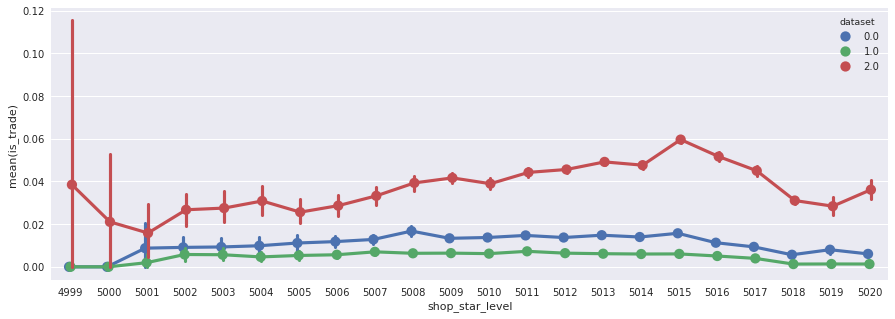

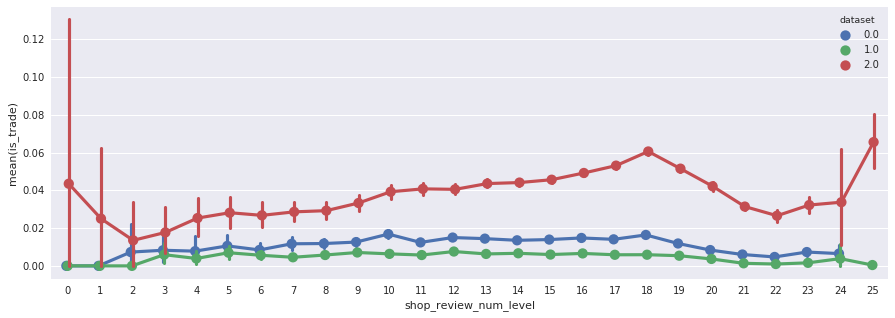

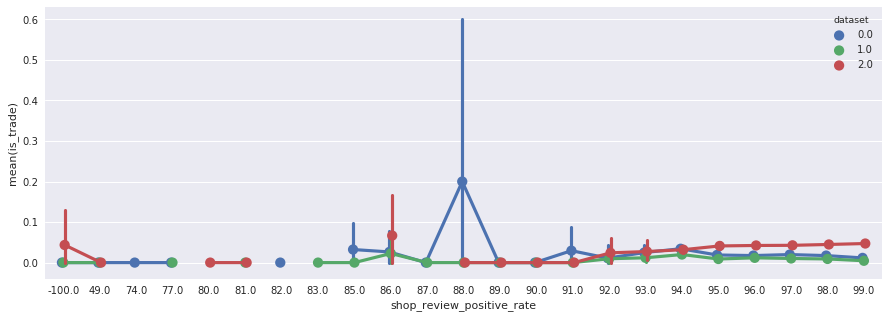

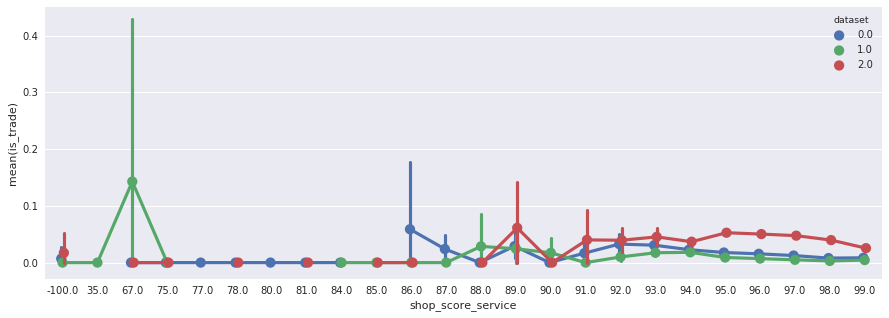

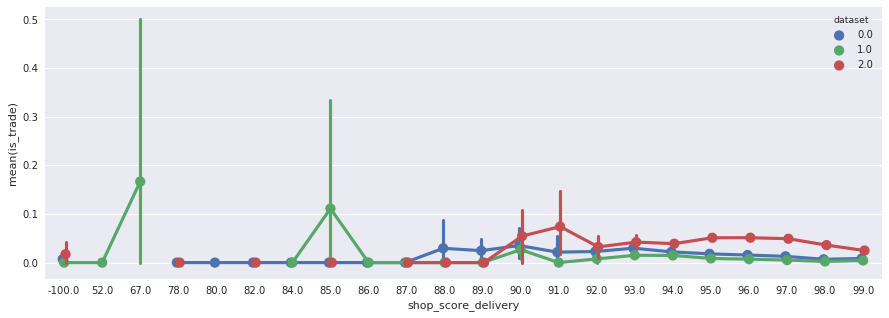

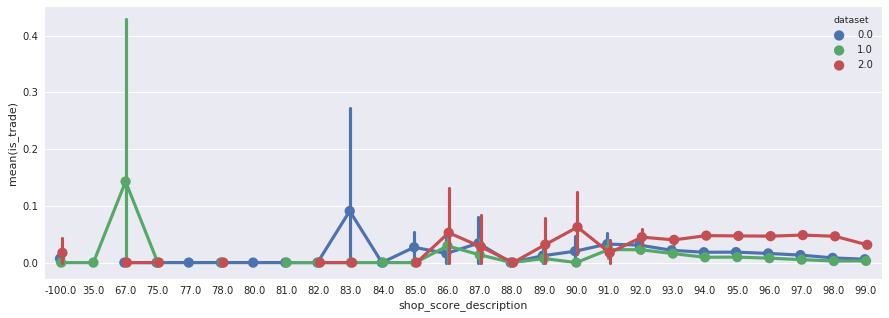

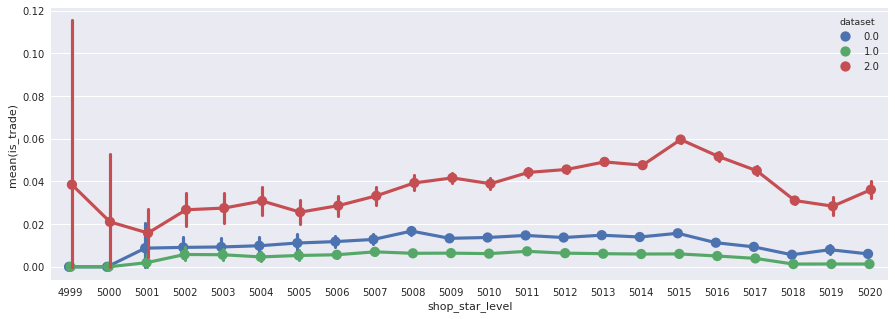

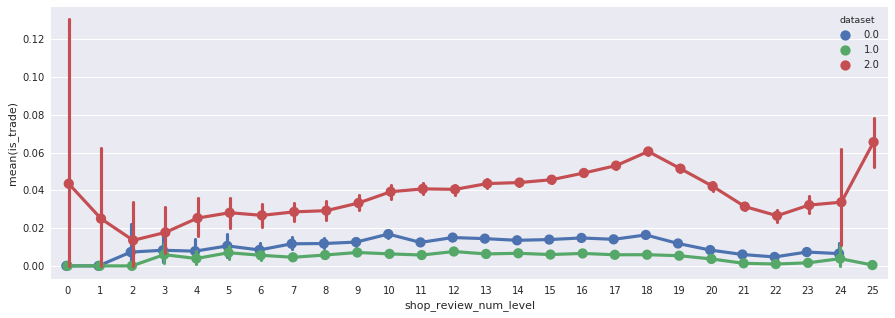

In [31]:
# 店铺特征
tempDf = df.fillna(-1)
cols = ['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description','shop_star_level','shop_review_num_level']
print(getFeaPearsonr(tempDf, cols))
tempDf.loc[:,['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description']] = tempDf[['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description']] // 0.01
# tempDf.loc[:,['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description']]
tempDf = df.copy()
tempDf.loc[tempDf.shop_star_level<5002, 'shop_star_level'] = 5002
tempDf.loc[tempDf.shop_review_num_level<4, 'shop_review_num_level'] = 3
tempDf.loc[tempDf.shop_review_num_level>23, 'shop_review_num_level'] = 24
printSingleFeaLine(tempDf, cols)